<a href="https://colab.research.google.com/github/gborn/Whatsapp_Chat_Analysis/blob/main/notebooks/02_topic_modelling_and_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import re

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=False, dpi=100)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

sns.set()

In [5]:
chats = pd.read_csv('group_chats.csv', parse_dates=['datetime'])
chats

,datetime,id,message
0,2021-10-05 11:16:00,Udaya,hi
1,2021-10-05 11:30:00,Udaya,Has anyone completed transfer learning assignm...
2,2021-10-05 11:30:00,Krishna,hi all
3,2021-10-05 16:11:00,Mahendra,<Media omitted>
4,2021-10-05 16:13:00,Sherya,df.age.isna() or df.age.isnull()
...,...,...,...
6315,2021-11-12 21:50:00,Raghvendra,Very nice article. 👏👏👏
6316,2021-11-12 23:44:00,Rohit,Anyone who is appearing or appeared for interv...
6317,2021-12-12 17:22:00,Sherya,Guys please anyone can share sample resume on ...
6318,2021-12-12 17:25:00,Ashish,Thank you :)


In [6]:
unique_users_to_message = chats.groupby(['id'], as_index=False)['message'].apply(' '.join)
unique_users_to_message.head(10)

,id,message
0,Aadesh,Yes It would not be same Once Google the error...
1,Aarav,Great job bro Congrats bro
2,Abhi,<Media omitted> Got them tq Thanks 👍 Yes Nice ...
3,Abhimanyu,<Media omitted> <Media omitted> 👍 👍
4,Abhinav,Eda assignment is mostly to see how you can ab...
5,Adarsh,"I got that email, completed only 2 assignments..."
6,Akshath,"Broadcasting, adding new dimension so it can g..."
7,Aman,i am new too. 😎 Hi Pulkit 👍 bro i am having pr...
8,Ambika,+1 Not 2021 but I am from 2020 batch Yes 🙌 Isn...
9,Aniket,Along with cuda makesure you have correct vers...


## Sentiment Analysis using BERT

In [22]:
str(['NEGATIVE (1.0)'][0]).split()[0].strip('()')

'NEGATIVE'

In [60]:
#!pip install flair > /dev/null

from flair.models import TextClassifier
from flair.data import Sentence
from operator import itemgetter

#source: https://towardsdatascience.com/the-best-python-sentiment-analysis-package-1-huge-common-mistake-d6da9ad6cdeb
sia = TextClassifier.load('en-sentiment')

@np.vectorize
def flair_prediction(x):
    sentence = Sentence(x)
    sia.predict(sentence)
    score = sentence.labels[0]
    return str(score)

df = unique_users_to_message.copy()
df['result'] = df['message'].apply(flair_prediction)
df['sentiment'] = df['result'].str.split(n=1, expand=True)[0]
df['score'] = df['result'].str.split(n=1, expand=True)[1]
df['score'] = df['score'].str.strip('()')
df['score'] = df['score'].astype('float')

df

2021-12-20 09:01:44,370 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


,id,message,sentiment,result,score
0,Aadesh,Yes It would not be same Once Google the error...,NEGATIVE,NEGATIVE (0.9619),0.9619
1,Aarav,Great job bro Congrats bro,POSITIVE,POSITIVE (0.9988),0.9988
2,Abhi,<Media omitted> Got them tq Thanks 👍 Yes Nice ...,NEGATIVE,NEGATIVE (0.9193),0.9193
3,Abhimanyu,<Media omitted> <Media omitted> 👍 👍,NEGATIVE,NEGATIVE (0.9974),0.9974
4,Abhinav,Eda assignment is mostly to see how you can ab...,NEGATIVE,NEGATIVE (0.9756),0.9756
...,...,...,...,...,...
131,Vijay,👍👍 👏👏👏👏 Great work Congratulations brother,POSITIVE,POSITIVE (0.9942),0.9942
132,Vinay,Thanks for sharing this is good 🙏 Are there an...,NEGATIVE,NEGATIVE (0.8743),0.8743
133,Virat,Thankyou @919652638618 I have also completed m...,POSITIVE,POSITIVE (0.5203),0.5203
134,Vivek,Guys this is out of topic question but i need...,NEGATIVE,NEGATIVE (0.7728),0.7728


## Topic Modelling using Top2Vec

In [ ]:
import re
from bs4 import BeautifulSoup
from nltk.stem.wordnet import WordNetLemmatizer

wnl = WordNetLemmatizer()
nltk.download('wordnet')

# list of custom stopwords
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't", 'hi', 'okay', 'ok', 'ohkay', 'bro', 'bye', 'thanks', 'thank', 'yeah', 'ya', \
            'u', 'ur', ])

# https://stackoverflow.com/a/47091490/4084039
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


def preprocess_text(sentence:str):

    #a. remove html and url tags from text
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()

    #b.expand contracted terms
    sentence = decontracted(sentence)

    #c.remove non aplhabet characters
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)

    #d. lemmatize each word in sentence
    #e. and turn them into lower case
    #list of stop words: https://gist.github.com/sebleier/554280
    sentence = ' '.join(wnl.lemmatize(word.lower()) for word in sentence.
    split() if word.lower() not in stopwords)
    
    return sentence


documents = chats['message'].apply(preprocess_text)
documents

In [33]:
!pip install top2vec > /dev/null
from top2vec import Top2Vec
model = Top2Vec(documents=unique_users_to_message['message'].tolist(), speed="learn", workers=4)
model.get_num_topics()

2021-12-19 17:20:00,385 - top2vec - INFO - Pre-processing documents for training
2021-12-19 17:20:00,461 - top2vec - INFO - Creating joint document/word embedding
2021-12-19 17:20:01,101 - top2vec - INFO - Creating lower dimension embedding of documents
2021-12-19 17:20:04,686 - top2vec - INFO - Finding dense areas of documents
2021-12-19 17:20:04,695 - top2vec - INFO - Finding topics


2

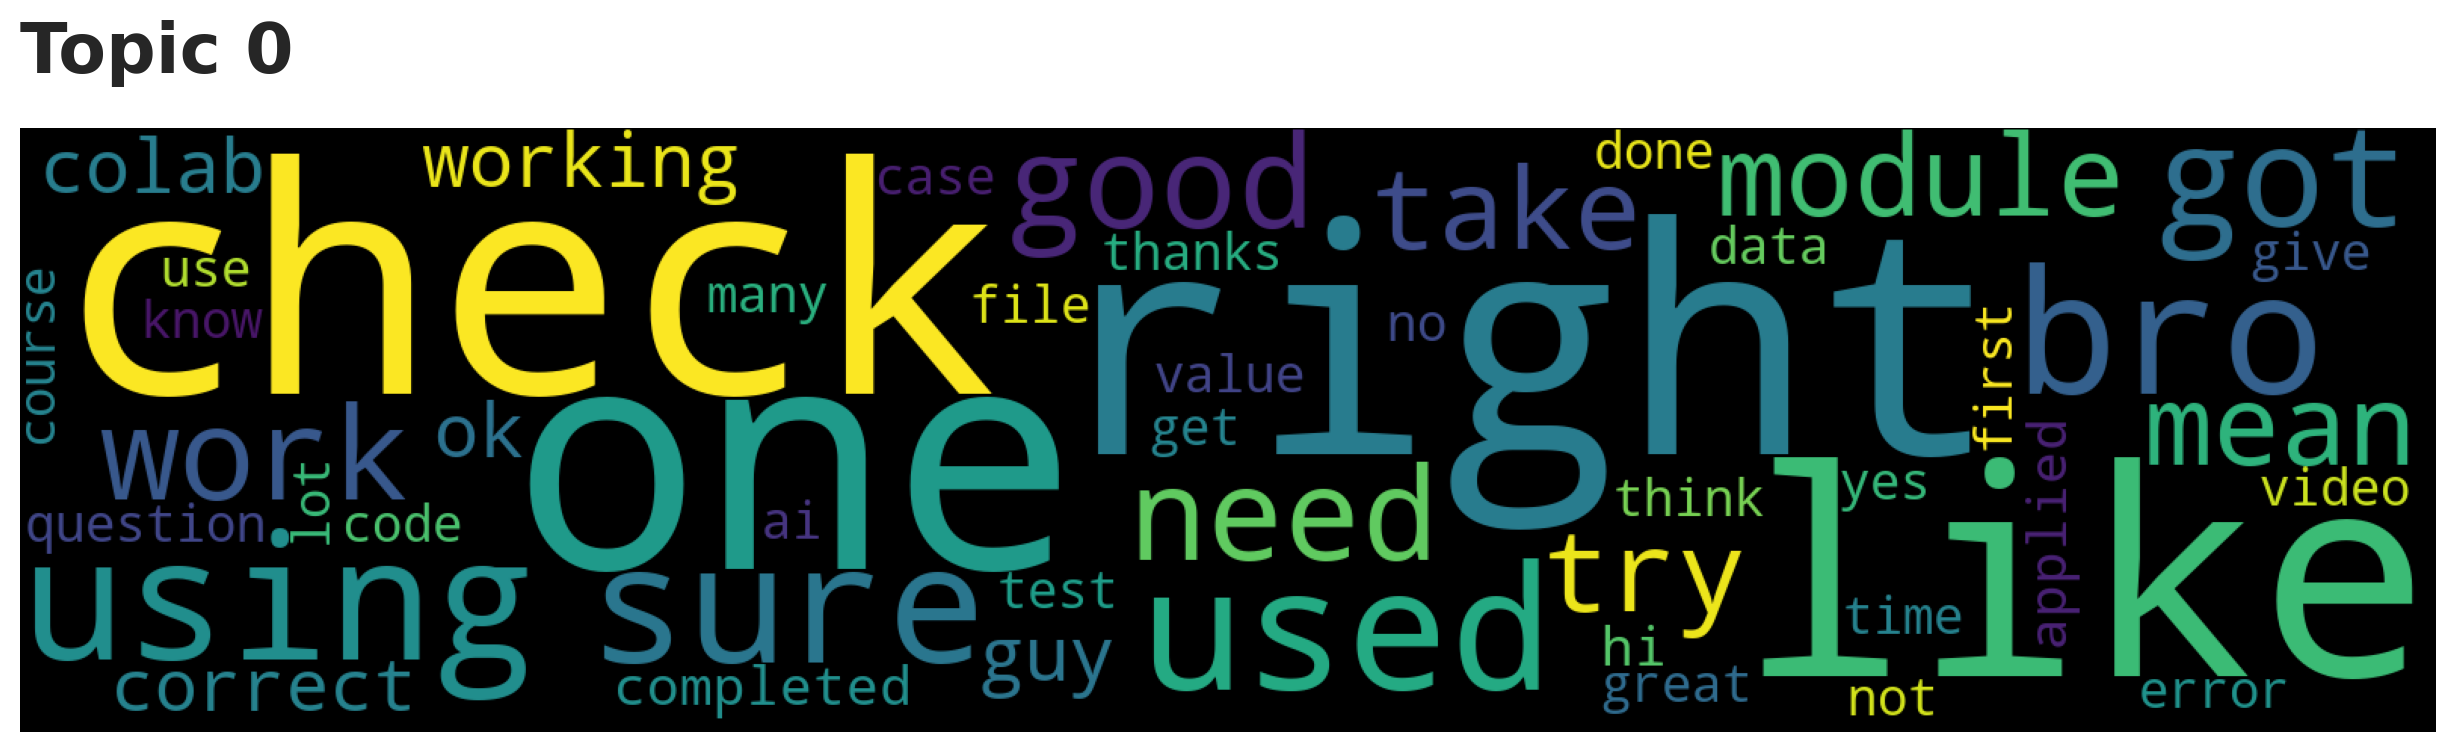

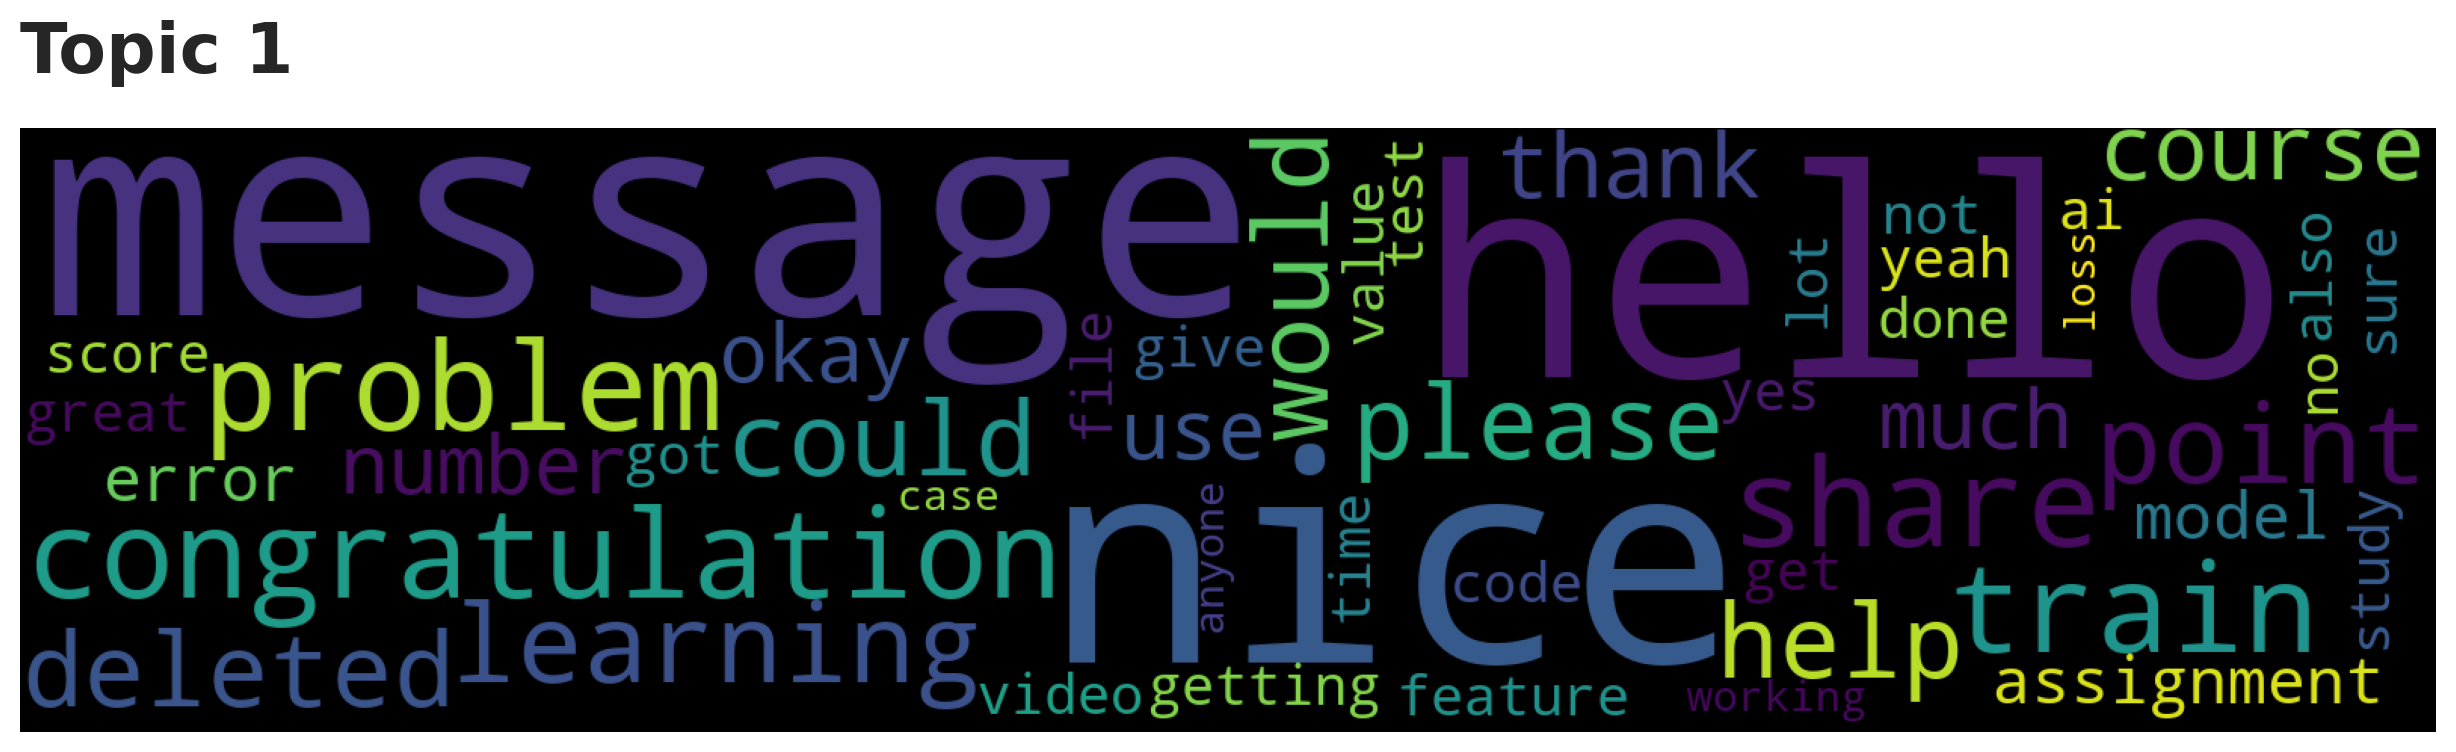

In [34]:
topic_words, word_scores, topic_nums = model.get_topics(model.get_num_topics())
for topic in topic_nums:
    model.generate_topic_wordcloud(topic)

In [35]:
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=0, num_docs=10)
documents

array(['eda assignment mostly see able get insight given data use bias correction adam optimization writing query question follow instruction anyone share rnn backpropagation blog yes take time min change no epoch actually calculating derivative ignoring minus sign hence using plus update equation message deleted yes plot data point scatter plot try plot line use n job used dataset drive local drive read np argsort documentation yes correct parallelized data point one model much time take hypermater tuning not asking best hyperparameter asking code training gbdt model completed python module watch live session code walk helped also non c back ground worked also part gradient checking grader function back propagation correct two path network please recheck network diagram add two path add step like malware assignment add add additional feature created development video awesome reason behind random forest work better gbdt intuition training time affect model performance get point think a